Filippo Nardi (100519009)</br>
Jaime Martínez (100451397)

# ***First optimization practice: distribution of manufactured goods along the US territory***

*Manufactured Goods Inc.*, no rights reserved, is a multinational company that manufactures all kinds of goods. As a company of this caliber, it is normal that some other companies are affiliated in a huge group along it, and it is the case of this optimization problem that us, the scholarship holders in the computing department, we have to face

The problem proposed is a logistics problem: we are asked to distribute our manufactured goods along all the US territory. In order to do so, we are offered help from the transportation department, which will be in charge of the distribution of the goods from our factories to the markets demanding our goods. However, they have asked us to seek for the best way in which the trucks can be deployed so that their fuel consumption during the delivery is minimal

In order to be able to distribute the manufactured goods, which in this case, they seem to be some kind of board game, it is first necessary to know the amount of pallets filled with the manufactured goods that we have to distribute and both their origins and destinations, or in other words, the factories from where the manufactured goods are created to the principal markets along the US. Notice that, since this kind of problems have to be tackled prior to the customer demanding it, since you cannot deliver a product to a certain market at the same time that it is bought, our mates in the computing department have provided us with some predictions for the following year, but since demand can vary, we opted to generate a random generator of demand along all posible markets for the sake of trying our code. However, this code can be slightly changed so that the demands can match with the given by our mates, which at the moment, is hidden to us

Some other constraints and restrictions we also have to face will be explained further into the report, precisely at the model initialization so that they can be explained on their due course, but the initial problem provided has been clearly stated and the information provided is the necessary for the prior data generation

In [208]:
# Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from pyomo.environ import *
from pyomo.opt import SolverFactory

Importing necessary libraries: pandas, numpy, random, matplotlib, math, Pyomo.

In [209]:
random.seed(33)
demand = random_numbers = [random.randint(400, 500) for _ in range(52)]
for i in range(43, 52): demand[i] += random.randint(50, 100)
for i in [0, 1]: demand[i] += random.randint(75, 100)


In order to get some feasible demand, which in a real problem it would be given as predictions by our mates in the department, we have used the randint() function to generate some variation during the weeks, whose output is always the same after having set a seed before. The demand predictions have also been subjected to some increase as we get closer to the end of the year, for obvious reasons, since the amount of toys sold during Christmas and Black Friday are always greater than during the rest of the year

Since the output is always the same, we thought that it could be better if we gave the possibility of generating a completely random output, which is achieved by the following cell of code when uncommented (we recommend to do so after a first iteration of the problem using the demand predefined by the seed we set). If we jump into the following code cell for a brief moment, we can see that the randomly generated demand of pallets acting as posible predictions for the following year are subjected to a normal distribution, whose parameters *mu* and *sigma* can be changed. Do not hesitate to change some of these values into another ones, and a comment will be written in every modifiable 

In [210]:
"""
# Uncomment all code for random values in demand

# 
mu, sigma = 500, 25 # Modifiable; mean and standard deviation of the normal used 
weeks = 52 # weeks in a year
demand = np.random.normal(mu, sigma, weeks)

counter = 0 # This variable is created to reflect the increasing amount of sales inversely proportional to time left before Christmas
multiplier = 15 # Modifiable; this value will be the responsible to increase the demand on the previous weeks to Christmas
for i in range(41, 52):
    demand[i] += abs(np.random.normal(counter * multiplier, 10)) # We assume a more or less linear increasing in November and December
    counter += 1
    
for i in [0, 1]: demand[i] += np.random.normal(counter * multiplier, 10)
#print(demand)

# The following lines of code just converts all values to integers for a more realist approach
# It also makes sure that no value drops below the lowerbound imposed
lowerbound = mu - 50
for i in range(weeks): 
    if demand[i] < lowerbound: 
        demand[i] = lowerbound
    else:
        demand[i] = int(demand[i])
"""

'\n# Uncomment all code for random values in demand\n\n# \nmu, sigma = 500, 25 # Modifiable; mean and standard deviation of the normal used \nweeks = 52 # weeks in a year\ndemand = np.random.normal(mu, sigma, weeks)\n\ncounter = 0 # This variable is created to reflect the increasing amount of sales inversely proportional to time left before Christmas\nmultiplier = 15 # Modifiable; this value will be the responsible to increase the demand on the previous weeks to Christmas\nfor i in range(41, 52):\n    demand[i] += abs(np.random.normal(counter * multiplier, 10)) # We assume a more or less linear increasing in November and December\n    counter += 1\n    \nfor i in [0, 1]: demand[i] += np.random.normal(counter * multiplier, 10)\n#print(demand)\n\n# The following lines of code just converts all values to integers for a more realist approach\n# It also makes sure that no value drops below the lowerbound imposed\nlowerbound = mu - 50\nfor i in range(weeks): \n    if demand[i] < lowerbound: 

Then, it would be best if we could visualize the demand obtained just to check that the predicted demand is feasible in real world, which in this case, seems that could happen in a real scenario, in where sales increase in November, December and the first weeks of January. Also notice that the sales keep more or less stable during the rest of the year, which makes sense

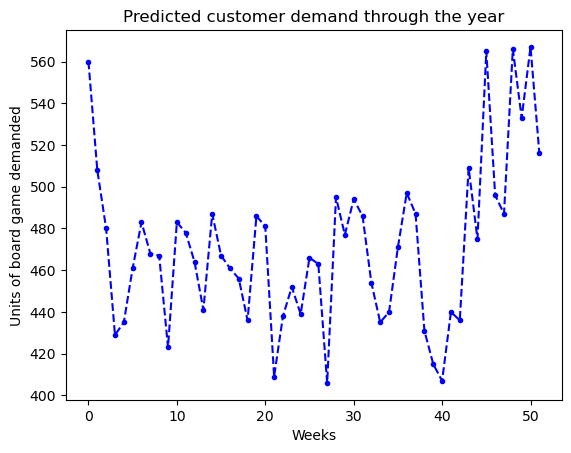

In [211]:
#print(demand)
plt.plot(demand, marker = ".", linestyle = "--", color = "blue")
plt.title("Predicted customer demand through the year")
plt.xlabel("Weeks")
plt.ylabel("Units of board game demanded")
plt.show()

After having defined our demands numerically, it is now time to distribute the demand throughout a defined map so that we are able to compute the different distances between our factories and the markets we are delivering our goods. In order to do so, and since the logistics department has not provided us neither the locations of the factories and markets nor the markets demands, we will also have to create a simulation of them by randomly assigning some demands to the some of the most important cities in the US, which will be the destinations of our goods. Notice that we will use the 40 most populated cities in the United States to define our main markets, and also notice that this number can be changed for a more broad approach. In order to select our factories locations, we will also locate them in cities, despite the fact that we could randomly select some coordinates across the map and select them to be the locations of our factories, but for simplicity we chose not to; also for simplicity, we will remove those cities laying in Hawaii and Alaska, since there is no room for road trips to both of those territories, which also have their own logistic system, which we are not allowed to access to

In [212]:
data = pd.read_csv("us2021census.csv")
data["Longitude"] = data["Longitude"].apply(lambda x: float(x))
data["Latitude"] = data["Latitude"].apply(lambda x: float(x))
df_sorted = data.sort_values(by = "Population", ascending = False)
df = df_sorted[df_sorted["State"].isin(["HI", "AK"]) == False]
df.head(3)

,City,State,Type,Counties,Population,Latitude,Longitude
0,New York,NY,City,Bronx;Richmond;New York;Kings;Queens,8804190,40.714,-74.007
1,Los Angeles,CA,City,Los Angeles,3898747,34.052,-118.243
2,Chicago,IL,City,Cook;DuPage,2746388,41.882,-87.628


In [213]:
n_markets = 40 # Modifiable; we recommend it to be a not small number
n_factories = 10 # Modifiiable
df_markets = df.iloc[0:n_markets]
df_factories = df.iloc[n_markets:n_markets + n_factories]
print("List of markets: " + str(list(df_markets["City"])))
print("List of factories: " + str(list(df_factories["City"])))

List of markets: ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Jacksonville', 'Fort Worth', 'Columbus', 'Indianapolis', 'Charlotte', 'San Francisco', 'Seattle', 'Denver', 'Washington', 'Nashville', 'Oklahoma City', 'El Paso', 'Boston', 'Portland', 'Las Vegas', 'Detroit', 'Memphis', 'Louisville', 'Baltimore', 'Milwaukee', 'Albuquerque', 'Tucson', 'Fresno', 'Sacramento', 'Kansas City', 'Mesa', 'Atlanta', 'Omaha', 'Colorado Springs']
List of factories: ['Raleigh', 'Long Beach', 'Virginia Beach', 'Miami', 'Oakland', 'Minneapolis', 'Tulsa', 'Bakersfield', 'Wichita', 'Arlington']


Taking a look onto the results provided by the dataset given to us, it seems that it only takes into account the population in the city center, and it does not consider any metropolitan area around the city under consideration, but it will work for us, since the latitude and longitude are defined properly, and the population was only a sorting criteria

In order to obtain the distances between these distances, since (unfortunately) the Google Maps API is not free and our multinational does not consider it to be an useful purchase, we opted to compute the distance in a straight line from the factories and markets using a simple Pitagoras Theorem approach using as parameters the latitudes and longitudes of the cities, which might be more or less similar to the real distance between the two points by road. Notice that to do so, we have imported the math package, which allows us to use the function *math.dist()*, which simplifies things a bit. Lastly, we have obtained a dataset in where the different cities in the United States and their coordinates appear; they are accompained with their population, which we use to sort our dataset in order to locate our factories and markets

In [214]:
distances_parameters = []
for idx_f, f in enumerate(df_factories["City"]):
    distances_parameters.append([])
    for idx_m, m in enumerate(df_markets["City"]):
        factory_params = [df.loc[df["City"] == f, "Longitude"].iloc[0], df.loc[df["City"] == f, "Latitude"].iloc[0]]
        market_params = [df.loc[df["City"] == m, "Longitude"].iloc[0], df.loc[df["City"] == m, "Latitude"].iloc[0]]
        distances_parameters[idx_f].append(math.dist(factory_params, market_params))

distances_df = pd.DataFrame(data = distances_parameters, index = df_factories["City"], columns = df_markets["City"])
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
distances_df


City,New York,Los Angeles,Chicago,Houston,Phoenix,Philadelphia,San Antonio,San Diego,Dallas,San Jose,Austin,Jacksonville,Fort Worth,Columbus,Indianapolis,Charlotte,San Francisco,Seattle,Denver,Washington,Nashville,Oklahoma City,El Paso,Boston,Portland,Las Vegas,Detroit,Memphis,Louisville,Baltimore,Milwaukee,Albuquerque,Tucson,Fresno,Sacramento,Kansas City,Mesa,Atlanta,Omaha,Colorado Springs
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Raleigh,6.767553,39.641680,10.864462,17.774492,33.516227,5.429660,20.844032,38.647649,18.403993,43.279980,19.883283,6.231583,18.935352,6.042861,8.511609,2.272317,43.820664,45.271189,26.643776,3.503260,8.153048,18.879578,28.137647,10.038424,45.103988,36.507094,7.896782,11.430596,7.536674,4.050883,11.772655,28.021645,32.529170,41.161127,42.948174,16.286808,33.276149,6.099095,18.148140,26.360277
Long Beach,44.727633,0.288543,31.622699,23.178164,6.126363,43.470112,20.175426,1.470181,21.417754,5.139380,20.746364,36.696591,20.885629,35.731948,32.591244,37.377486,5.824211,14.446703,14.492235,41.474118,31.500256,20.745770,11.875002,47.911517,12.578520,3.881329,36.173376,28.173720,32.744165,41.941964,31.675060,11.614795,7.382688,3.371256,5.834629,24.204499,6.370787,33.802005,23.479386,14.296888
Virginia Beach,4.340305,42.361176,12.695948,20.642930,36.259476,3.210849,23.707727,41.397429,21.215877,45.919625,22.740851,8.646836,21.745292,7.687289,10.595453,5.130798,46.449411,47.596651,29.156979,2.308754,10.830431,21.585965,30.934793,7.387901,47.503635,39.175798,8.951787,14.180151,9.884373,2.526661,13.444388,30.728502,35.303005,43.815133,45.554937,18.745612,36.020679,8.967401,20.448310,28.916350
Miami,16.169658,38.941031,17.741526,15.685899,32.792563,15.043154,18.658296,37.619066,18.022876,43.272236,18.117219,4.783842,18.505829,14.463396,15.213585,9.475390,43.895801,47.465411,28.457218,13.495221,12.304202,19.851816,26.968719,18.934372,46.850936,36.465599,16.802333,13.603455,13.667279,13.980349,18.912276,28.050093,31.449112,41.086613,43.242771,19.616059,32.548598,9.012426,22.086550,27.877379
Oakland,48.351647,5.504751,34.882195,28.084629,11.088442,47.155947,25.214621,7.208258,25.964499,0.602847,25.659581,41.296338,25.446141,39.329249,36.166421,41.508073,0.145000,9.803229,17.391977,45.248155,35.525874,24.864974,16.900681,51.416163,7.725781,7.311691,39.484490,32.328454,36.516810,45.680144,34.762891,15.854071,12.601727,2.701632,1.094602,27.718502,11.325057,38.097417,26.556835,17.479256
Minneapolis,19.731026,27.256311,6.436906,15.359993,22.055227,18.792293,16.405927,26.855308,12.695198,29.621479,15.373501,18.694957,12.879333,11.429946,8.816590,15.796916,30.017544,29.184744,12.832688,17.337774,10.944226,10.413098,18.690954,22.368732,29.411994,23.578168,10.561565,10.344900,10.081350,17.601392,5.705166,16.640188,21.817778,27.767767,28.940528,6.017545,21.865871,14.316351,4.575403,13.082948
Tulsa,22.452149,22.350967,10.137120,6.423771,16.308891,21.170648,7.178990,21.451136,3.466990,25.927003,6.140255,15.472368,3.653601,13.536934,10.476800,15.176277,26.473044,28.729054,9.684390,19.152300,9.208007,1.671780,11.379168,25.694723,28.283764,19.153008,14.343193,6.023767,10.448042,19.628140,10.622698,10.714461,15.489128,23.805165,25.619930,3.269689,16.074895,11.847465,5.107255,9.228413
Bakersfield,45.327767,1.532063,32.058727,24.312797,7.206847,44.093404,21.373871,3.239902,22.372656,3.478757,21.879881,37.701075,21.845560,36.309162,33.153735,38.176279,4.161691,12.676219,14.695543,42.130473,32.245703,21.503210,13.041462,48.468110,10.785959,3.956315,36.638947,28.967889,33.386795,42.584437,32.045196,12.370376,8.641002,1.566332,4.049833,24.719192,7.449907,34.667060,23.817998,14.612306
Wichita,23.526673,21.218506,10.577831,8.168360,15.333308,22.289483,8.342918,20.440421,4.934745,24.555494,7.429048,17.321487,4.932005,14.516534,11.372392,16.677281,25.076176,26.896584,7.919723,20.337967,10.664169,2.225131,10.901375,26.693218,26.523992,17.870335,15.027242,7.716048,11.595068,20.784906,10.847499,9.670626,14.689061,22.471048,24.174425,3.0985

The procedure to create the previous table was the following: with the creation of a nested loop we can traverse the entire list of factories and markets provided, and extract their longitude and latitude. This allows us to insert them as parameters in some auxiliary lists which are used directly into the *math.dist()* function. This pandas dataframe will be constantly used in the described problem, but before that, we need a prior management of the data given so that we can approach the creation of the model without any complication

Notice that the distance is not given in neither kilometers nor milles, but a floating point which describe the proportional distance between the factories and the markets. This would be much easier if our CEOs had decided that the Google Maps API was a worthy purchase, but as the distance is given in an scalar value proportional to the real distance, the optimization problem is not affected by it

Now it is time to define the production rates of the factories. In order to do this, we are selecting just one week (in order to get the demand from it and which is represented by the variable *s_week*) and we will also assume that the demand is fulfilled with, at least, the same amount of offer from the factories. This is achieved by setting the *additional_production* variable with a value equal or greater than 0, which is a parameter created for adding an excedent into the factories production. With the intrusion of this parameter, it will be worth saying that the costs of the fuel consumption will fall, since there would be no restriction to force some truck drivers to drive a huge dstance between a factory in, for example, the middle of the US to its destination in Maine, since there would be nearer factories with spare production ready to be exported

The way we are doing this is completely based on randomly generated data, but new functions can be implemented in order to maintain a feasible real scenario, like obtaining a random measure from a normal distribution with its mean as the total population of the markets and then operating and normalizing the whole list of values so that those values fit proportionally in the demand constraints

Notice that in the code cell below there are also initialized some functions at the end of it, we will explain their usage posteriorly

In [215]:
s_week = 12 # Modifiable
weekly_demand = demand[s_week]
additional_production = 0 # Modifiable, this variable, if increased, adds more production to the factories, which creates excedents in production
random.seed(33) # The removal of this line provide different in every execution

def partitions(number, x):
    partitions = sorted(random.sample(range(number), x - 1))
    partitions = [partitions[0]] + [partitions[i] - partitions[i - 1] for i in range(1, x - 1)] + [number - partitions[-1]]
    return partitions

demand_partitioned = partitions(weekly_demand, len(df_markets["City"]))
production_partitioned = partitions(weekly_demand + additional_production, len(df_factories["City"]))
print("Production equal or higher than the demand?: " + str(sum(demand_partitioned) <= sum(production_partitioned)))
print("Demand per market: " + str(demand_partitioned))
print("Production per factory: " + str(production_partitioned))

def generate_dict(l1, l2):
    d = {}
    for idx, i in enumerate(l1):
        d[i] = l2[idx]
    return d

def generate_dist_dict(l_f, l_m, df):
    d = {}
    for i in l_f:
        for e in l_m:
            d[i, e] = df.loc[i, e]
    return d

def cost(model, factory, market): # may add fuel_price/type, discount and/or surcharge/tax
    return model.Distances[factory, market] 

Production equal or higher than the demand?: True
Demand per market: [26, 10, 49, 10, 24, 22, 3, 10, 4, 6, 47, 7, 9, 18, 1, 8, 3, 8, 5, 2, 20, 19, 4, 8, 2, 8, 11, 2, 5, 25, 4, 37, 1, 12, 10, 10, 6, 4, 3, 1]
Production per factory: [60, 65, 18, 20, 121, 64, 43, 42, 9, 22]


The sum of all the production is, at least, equal to the sum of all the demand, so we can conclude that the demand will be fully satisfied. It is also printed both a list in where all the different demands of the markets are stored in and a list in where the production rates are also stored in, just for the sake of data visualization without crowding the output window with redundant strings. And from now on, since we have all the variables we would need to create the model, it is just a matter of creating a Pyomo model and initializing the different parameters and variables using the data inferred above, as the amount of pallets of board games assigned to each factory (for production) and market (for demand)

So, in order to generate the base sets of information we will be using constantly along all the problem, factories and markets, it is necessary to extract a list of the strings on the indexes of the dataframe created above. These correspond to the name of the cities in where the factories and the markets are set on, and whenever we have to extract a certain distance value, we will have to access precisely the row and the column whose indexes are the cities names

After having initialized the "factories" and "markets" sets, we can compute some parameters using those as variables, like the production or demand required to be satisfied. Those two parameters are created based on the output of the *generate_dict()* function; the purpose of this function is the creation of a dictionary whose keys are lists containing the names of each factory and each market, and the dictionary values are assigned precisely from the randomly generated list created on the code cell above, whose values are assigned to both the "Production" and the "Demand" parameters. The procedure for the creation of the "Distances" parameter is similar, since in this case we are using the second function, *generate_dist_dict()*, in order to obtain a dictionary whose key is are a consecution of lists consisting on each factory appended together with each market, so that all distances (as mentioned above, using the *math.dist()* approach) between origins and destinations can be obtained

In [216]:
model = ConcreteModel("Logistics Problem")

model.factories = Set(initialize = list(df_factories["City"]), doc = "Factories")
model.markets = Set(initialize = list(df_markets["City"]), doc = "Markets")

model.Production = Param(model.factories, initialize = generate_dict(list(df_factories["City"]), production_partitioned), doc = "Factories production")
model.Demand = Param(model.markets, initialize = generate_dict(list(df_markets["City"]), demand_partitioned), doc = "Markets demand")
model.Distances = Param(model.factories, model.markets, initialize = generate_dist_dict(list(df_factories["City"]), list(df_markets["City"]), distances_df), doc = "Distances")

Now, we have all the necessary parameter to enter in depth in the optimization problem provided. The first step seems simple, and in fact, it is, which is the assignation of the production of each factory to the optimal market to be exported to. The variable *pallets_transported* assigned in the model will be the one in change of storing the necessary pallets filled with board games to be delivered to their destination

Notice that the initialization of this variable is discrete as it is defined within the non negative integers but, since the delivery of half a pallet, despite being feasible, is a zero-sense demand for us, and since we are not able to provide any market half a board game for obvious reasons, we have been working from the beginning with integers

And now, it is time where new restrictions are set. Firstly, our logistics department is trying to adapt to the new governmental restrictions to fossil fuels. This is why, despite having a huge truck fleet consisting in diesel trucks, they have been trying to get rid of them by the purchase of new gas trucks, which pollute less than the diesel ones. That is the reason why they have a limited amount of diesel trucks (but, thanks to the agreements made with other logistics companies, they can hire, or be hired, some other diesel trucks, which in fact means that this number can be modified in the code below; notice that the parameter *diesel_trucks_available* has the "Modifiable" label)

But, talking about the governmental restrictions, a restriction to diesel regulates the maximum distance diesel trucks are allowed to drive. This means that no diesel trucks can drive from a factory to a market whose distace between them is higher than the estipulated by the government. And, of course, it is a must to refill the trucks fuel tank, so we have to take into account the cost of the trip. Notice that both these parameters are also subject to moifications, due to social agreement on the first one, and Exxon and OPEP production rates of fuel on the second one

So, having defined all this, and leaving the constraints for the inmediate further code cell, we opted to define some more variables. Firstly, since the demand is estipulated in pallets, we have to initialize a variable containing them, and since the pallets are being transported in trucks, then both the trcusk and their capacity have to be taken into account in the code too. And to define the type of trucks, a binary variable is added too, which is defined as a 1 if a truck is diesel-type and as a 0 if it moves using gas as fuel. Of course, the initialization of their prices on the gas station is also a must, as well as a parameter that defines the amount of diesel trucks the logistics department has and the maximum distance they can travel

So, taking into account that we have to analyze the total cost of the distance travelled appended to the type of fuel that the truck consumes, we have to try to minimize the costs of fuel consumption. The inmediate thought is that we will try to squeeze out the diesel trucks performance, and then leave the rest of the demand orders for gas trucks, since the diesel price is lower than the gas price. If it was the opposite, then we would not use any of the diesel trucks. And lastly, just as a comment, we are taking into account that the total distance in kilometers/milles is proportional to the distances we are working with due to the *math.dist()* not being a perfect measure, mainly, to earth surface being round, whose inmediate effect is to trastocate the distances between cities (the Google Maps API not being for free really modifies the results), so the use of kilometers and milles, despite having been explained before, would not imply any real change and it would ony create some more problems at the time of transforming the different distances into real world measures

In [217]:
model.pallets_transported = Var(model.factories, model.markets, doc = 'Pallets transported', within = NonNegativeIntegers)
model.pallets_per_truck = Param(default = 10, doc = "Pallets per truck") # Modifiable
model.trucks_used = Var(model.factories, model.markets, doc='Trucks used', within = NonNegativeIntegers)

model.Fuel = Var(model.factories, model.markets, domain = Binary, doc = "Type of fuel required") # 1 if diesel, 0 if gas
model.diesel_trucks_available = Param(default = 20, doc = "Diesel trucks available") # Modifiable
fuel_prices = {"Diesel": 1.55, "Gas": 1.75} # Modifiable
model.fuel_prices = Param(fuel_prices.keys(), initialize = fuel_prices, doc = "Fuel type")
model.max_distance_diesel_trucks = Param(default = 20, doc = "Maximum distance a diesel truck can move") # Modifiable

"""
def objective_rule(model):
    return sum((model.Distances[i, j] * model.trucks_used[i, j] * model.fuel_prices["Gas"] * (1 - model.Fuel[i, j])) + (model.Distances[i, j] * model.trucks_used[i, j] * model.fuel_prices["Diesel"] * model.Fuel[i, j]) for i in model.factories for j in model.markets)

"""
def objective_rule(model):
    return sum((model.Distances[i, j] * model.fuel_prices["Gas"] * (1 - model.Fuel[i, j])) + (model.Distances[i, j] * model.fuel_prices["Diesel"] * model.Fuel[i, j]) for i in model.factories for j in model.markets)

model.objective = Objective(rule = objective_rule, sense = minimize, doc = 'Transportation cost')


IMPORTANT NOTE: Please notice that a commented objective rule appears in the previous code cell. That should be the objective rule applicable to our problem, since we have to apply the cost of the transportation for each truck that traverses any route from any factory to any market, but whenever trying to compute the optimal solution using the solver *glpk*, an error is raised, consisting in the non-transformation of the problem to a linear one, but the addition of the variable *trucks_used[i, j]* would imply that the constraint *trucks_used_constraint* posteriorly defined is non-linear, which in fact, it linear; and the *gurobi* solver just lasts too much time and gets stuck trying to compute it, so we had to opt to remove the variable *trucks_used[i, j]* from the objective rule despite the fact that it should be there. Maybe you are able to find any mistake we have done and which we were not able to acknowledge, but we will continue with this objective rule for the sake of the problem solving

Before starting with all the mathematical definitions of the constraints, let's define the variables in a mathematical formulation, where f is the number of factories and m is the number of markets:

$I$ = $\{1, 2, 3,\dots, f\}$, $I \in \mathbb{Z}$</br>
$J$ = $\{1, 2, 3,\dots, m\}$, $J \in \mathbb{Z}$</br>
$P_g$ = Gas price (base at 1.55)</br>
$P_d$ = Diesel price (base at 1.75)</br>
$Pt$ = Amount of pallets a truck can transport (base at 10)</br>
$Da$ = Amount of diesel trucks available (base at 20)</br>
$Dmax$ = Distance which diesel trucks are not allowed to travel along (base at 20)

$P_i$ = production at factory $i$</br>
$D_j$ = demand at market $j$</br>
$d_{ij}$ = distance from factory $i$ to market $j$

$x_{ij}$ = Amount of pallets transported from factory $i$ to market $j$</br>
$t_{ij}$ = Amount of trucks used for the transportation from factory $i$ to market $j$</br>
$y_{ij}$ = 1 if a diesel truck is used for the delivery between factory $i$ to market $j$; 0 otherwise (gas truck)

And now, it is time to define our constraints. Firstly, it is necessary to create two of them to make sure that the production rates and the demands rates are both feasible amounts. This is achieved by creating a constraint that checks that all of the production directed to a certain market is, at least, the demanding amount of manufactured goods selected before. In other words, it is the equivalent of suming up all pallets that are being transported to a certain market and check that the sum is equal or higher than the predicted demand ($D_j$); notice that this process has to be iterated for all markets. And the creation of the second constraint is similar, but in this case we have to check that all pallets being transported from a certain factory to all the different markets do not exceed the amount of production that the certain factory can handle, and it is done by suming up all pallets whose route coincide with a certain factory and check that are less or equal than the factory production rate ($P_i$, this process also has to be iterated throughout all the factories)

But those are not the only constraints needed. Since the pallets have to be transported in truck, and the trucks have a certain capacity, it is worth estipulating a rule that regulates the amount of trucks needed to transport a certain amount of pallets ($t_{ij}$, depending on $x_{ij}$) in a certain route, which will take an integer higher to the amount of pallets transported (it will take the inmediate higher integersince we are minimizing) divided by the standard capacity of the trucks ($Pt$)







Objective function & constraints:</br>
$min. \sum_{i = 1}^{f}\sum_{j = 1}^{m}(d_{ij}t_{ij}P_g(1-y_{ij})+d_{ij}t_{ij}P_dy_{ij})$

$s.t.$</br>
$\sum_{j = 1}^{m}x_{ij}\leq P_i$, $\forall$ $i$ in $I$</br>
$\sum_{i = 1}^{f}x_{ij}\geq D_j$, $\forall$ $j$ in $J$</br>
$t_{ij} \geq \frac{x_{ij}}{Pt}$, $\forall$ $i, j$ in $I, J$</br>
$\sum_{i = 1}^{f}\sum_{j = 1}^{m}t_{ij}y_{ij} \leq Da$, $\forall$ $i, j$ in $I, J$</br>
$y_{ij} = 0$, $\forall$ $i, j$ in $I, J$ if $d_{ij} \geq D_{max}$</br>

In [218]:
def check_production(model, factory):
  return sum(model.pallets_transported[factory, market] for market in model.markets) <= model.Production[factory]

model.Constraint_Check_Production = Constraint(model.factories, rule = check_production, doc = 'Production at the factory')
    
def check_demand(model, market):
  return sum(model.pallets_transported[factory, market] for factory in model.factories) >= model.Demand[market]

model.Constraint_Check_Demand = Constraint(model.markets, rule = check_demand, doc = 'Demand at the market' )

def trucks_used_constraint_rule(model, factory, market):
  return (model.trucks_used[factory, market] >= model.pallets_transported[factory, market] / model.pallets_per_truck)

model.trucks_used_constraint = Constraint(model.factories, model.markets, rule = trucks_used_constraint_rule, doc = "Trucks used constraint")

def diesel_trucks_available(model):
  return sum(model.Fuel[factory, market] for factory in model.factories for market in model.markets) <= model.diesel_trucks_available

model.diesel_trucks_constraint = Constraint(rule = diesel_trucks_available, doc = "Diesel trucks available")
def diesel_restrictions(model, factory, market):
  return model.Fuel[factory, market] == 0 if value(model.Distances[factory, market]) >= model.max_distance_diesel_trucks else Constraint.Skip

model.diesel_restrictions_constraint = Constraint(model.factories, model.markets, rule = diesel_restrictions, doc = "Diesel restrictions")

So, in the end, using these constraints we are finally able to and generate the optimal distribution of trucks all along the US territory according to the department and government restrictions. One of the lasts steps to get the information needed is to define the solver and check the display of the desired variable. Then, for the sake of a better visualization, we will use the results to create a dataframe with them, so that we can clearly tell our logistics department how many trucks and which from which type have to be movilized to travel through a certain trajectory

Note: for the sake of data visualization, we have only selected those values that differ from zero, since it is a non-sense to define a lot of routes that will not be traversed, so we will focus on those routes that movilizes trucks, which actually matter for the logistics department

In [219]:
Solver = SolverFactory('glpk')
Results = Solver.solve(model)

model.trucks_used.display()

trucks_used : Trucks used
    Size=400, Index=trucks_used_index
    Key                                    : Lower : Value : Upper : Fixed : Stale : Domain
              ('Arlington', 'Albuquerque') :     0 :   0.0 :  None : False : False : NonNegativeIntegers
                  ('Arlington', 'Atlanta') :     0 :   0.0 :  None : False : False : NonNegativeIntegers
                   ('Arlington', 'Austin') :     0 :   0.0 :  None : False : False : NonNegativeIntegers
                ('Arlington', 'Baltimore') :     0 :   0.0 :  None : False : False : NonNegativeIntegers
                   ('Arlington', 'Boston') :     0 :   0.0 :  None : False : False : NonNegativeIntegers
                ('Arlington', 'Charlotte') :     0 :   0.0 :  None : False : False : NonNegativeIntegers
                  ('Arlington', 'Chicago') :     0 :   0.0 :  None : False : False : NonNegativeIntegers
         ('Arlington', 'Colorado Springs') :     0 :   0.0 :  None : False : False : NonNegativeIntegers
    

In [220]:
trucks_values = [value(model.trucks_used[key]) for key in model.trucks_used]
trucks_df = pd.DataFrame(trucks_values)

trucks_dict = {}
for v in model.component_data_objects(Var):
    if value(v) != 0:
        trucks_dict[v.index()] = int(value(v))
        

trucks_2_df = pd.DataFrame(trucks_dict.items(), columns=['Route', 'Trucks'])
trucks_2_df["Distances"] = [model.Distances[key] for key in trucks_2_df['Route']]
trucks_2_df["Fuel type"] = ["Gas truck" if value(model.Fuel[key]) == 0 else "Diesel truck" for key in trucks_2_df["Route"]]
trucks_2_df

,Route,Trucks,Distances,Fuel type
0,"(Raleigh, New York)",3,6.767553,Gas truck
1,"(Raleigh, Los Angeles)",1,39.641680,Gas truck
2,"(Raleigh, Chicago)",3,10.864462,Gas truck
3,"(Raleigh, Charlotte)",1,2.272317,Gas truck
4,"(Raleigh, Seattle)",1,45.271189,Gas truck
5,"(Raleigh, Washington)",1,3.503260,Gas truck
6,"(Raleigh, Nashville)",1,8.153048,Gas truck
7,"(Long Beach, Chicago)",4,31.622699,Gas truck
8,"(Long Beach, Houston)",1,23.178164,Gas truck
9,"(Long Beach, Phoenix)",2,6.126363,Gas truck


And this previous table is the one that matters for our logitics department. Notice that no diesel truck drives throught any route whose distance is higher than 20 units (taking into account we are using the base case) so the government diesel restrictions are followed and no fine can be imposed to us; and also check that the amount of diesel trucks does not exceed the amount previously defined (which is 20 in the base case), so there is no trouble at the time of assigning inexistent diesel trucks to any route that the program would estipulate. Notice that, as mentioned some paragraphs above, since the diesel price is lower than gas price, it is understandable that the program would try to assign all the diesel trucks in the longest possible routes, and based on the obtained results, we consider that hypothesis to be true: all diesel trucks are assigned and no one of these travel more than the maximum estipulated distance, and in fact, they get very close to it. This is not the case as if the gas price is lower than diesel price, since all trucks would be asigned to be gas trucks since the fuel consumption is lower and no constraint restricts them to travel less than a certain distance (you can check it by lowering the gas price or increasing the diesel price in the model initialization)